In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils.dataframe import read_final_csv

df = read_final_csv("boosting_model")

In [2]:
from utils.dataframe import delete_columns

last_n_matches = [5, 10, 20, 50]
df = delete_columns(df, last_n_matches)

In [3]:
list(df)

['player_1_entry_ALT',
 'player_1_entry_Alt',
 'player_1_entry_LL',
 'player_1_entry_PR',
 'player_1_entry_Q',
 'player_1_entry_SE',
 'player_1_entry_WC',
 'player_1_hand_L',
 'player_1_hand_R',
 'player_2_entry_ALT',
 'player_2_entry_Alt',
 'player_2_entry_LL',
 'player_2_entry_PR',
 'player_2_entry_Q',
 'player_2_entry_SE',
 'player_2_entry_WC',
 'player_2_hand_L',
 'player_2_hand_R',
 'tourney_year',
 'tourney_month',
 'tourney_day',
 'surface_Carpet',
 'surface_Clay',
 'surface_Grass',
 'surface_Hard',
 'surface_h2h_diff',
 'elo_surface_diff',
 'tourney_level_A',
 'tourney_level_D',
 'tourney_level_F',
 'tourney_level_G',
 'tourney_level_M',
 'rank_diff',
 'rank_points_diff',
 'original_rank_diff',
 'ht_diff',
 'age_diff',
 'h2h_diff',
 'ace_total_diff',
 'ace_last_5_surface_diff',
 'ace_last_5_diff',
 'ace_last_10_surface_diff',
 'ace_last_10_diff',
 'ace_last_20_surface_diff',
 'ace_last_20_diff',
 'ace_last_50_surface_diff',
 'ace_last_50_diff',
 'df_total_diff',
 'df_last_5_sur

In [4]:
len(df.columns)

137

In [5]:
correlations = df.corr(numeric_only=True)['player_1_won'].drop('player_1_won')
sorted_corrs = correlations.abs().sort_values(ascending=False)

strongest_corrs = correlations.loc[sorted_corrs.index]
print(strongest_corrs)

elo_diff                  0.374787
elo_surface_diff          0.357317
last_20_win_ratio_diff    0.325704
last_20_match_won_diff    0.325704
last_10_win_ratio_diff    0.318537
                            ...   
surface_Clay             -0.000844
player_1_entry_Alt       -0.000842
tourney_month             0.000507
tourney_level_D           0.000154
player_2_entry_SE        -0.000016
Name: player_1_won, Length: 136, dtype: float64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95375 entries, 0 to 95374
Columns: 137 entries, player_1_entry_ALT to player_1_won
dtypes: bool(28), float64(98), int64(11)
memory usage: 81.9 MB


In [7]:
split_year = 2022

x_train = df[df["tourney_year"] < split_year].drop("player_1_won", axis=1)
y_train = df[df["tourney_year"] < split_year]["player_1_won"]

x_val = df[df["tourney_year"] == split_year].drop("player_1_won", axis=1)
y_val = df[df["tourney_year"] == split_year]["player_1_won"]

x_test = df[df["tourney_year"] > split_year].drop("player_1_won", axis=1)
y_test = df[df["tourney_year"] > split_year]["player_1_won"]

In [8]:
train_data = x_train.join(y_train)
target_corr = train_data.corr()['player_1_won'].abs()
highly_corr_features = target_corr[target_corr >= 0.3].index.tolist()

print(f"There are {len(highly_corr_features)} highly correlated features:")
print(highly_corr_features)

There are 10 highly correlated features:
['elo_surface_diff', 'last_10_match_won_diff', 'last_20_match_won_diff', 'last_50_match_won_diff', 'win_ratio_diff', 'last_10_win_ratio_diff', 'last_20_win_ratio_diff', 'last_50_win_ratio_diff', 'elo_diff', 'player_1_won']


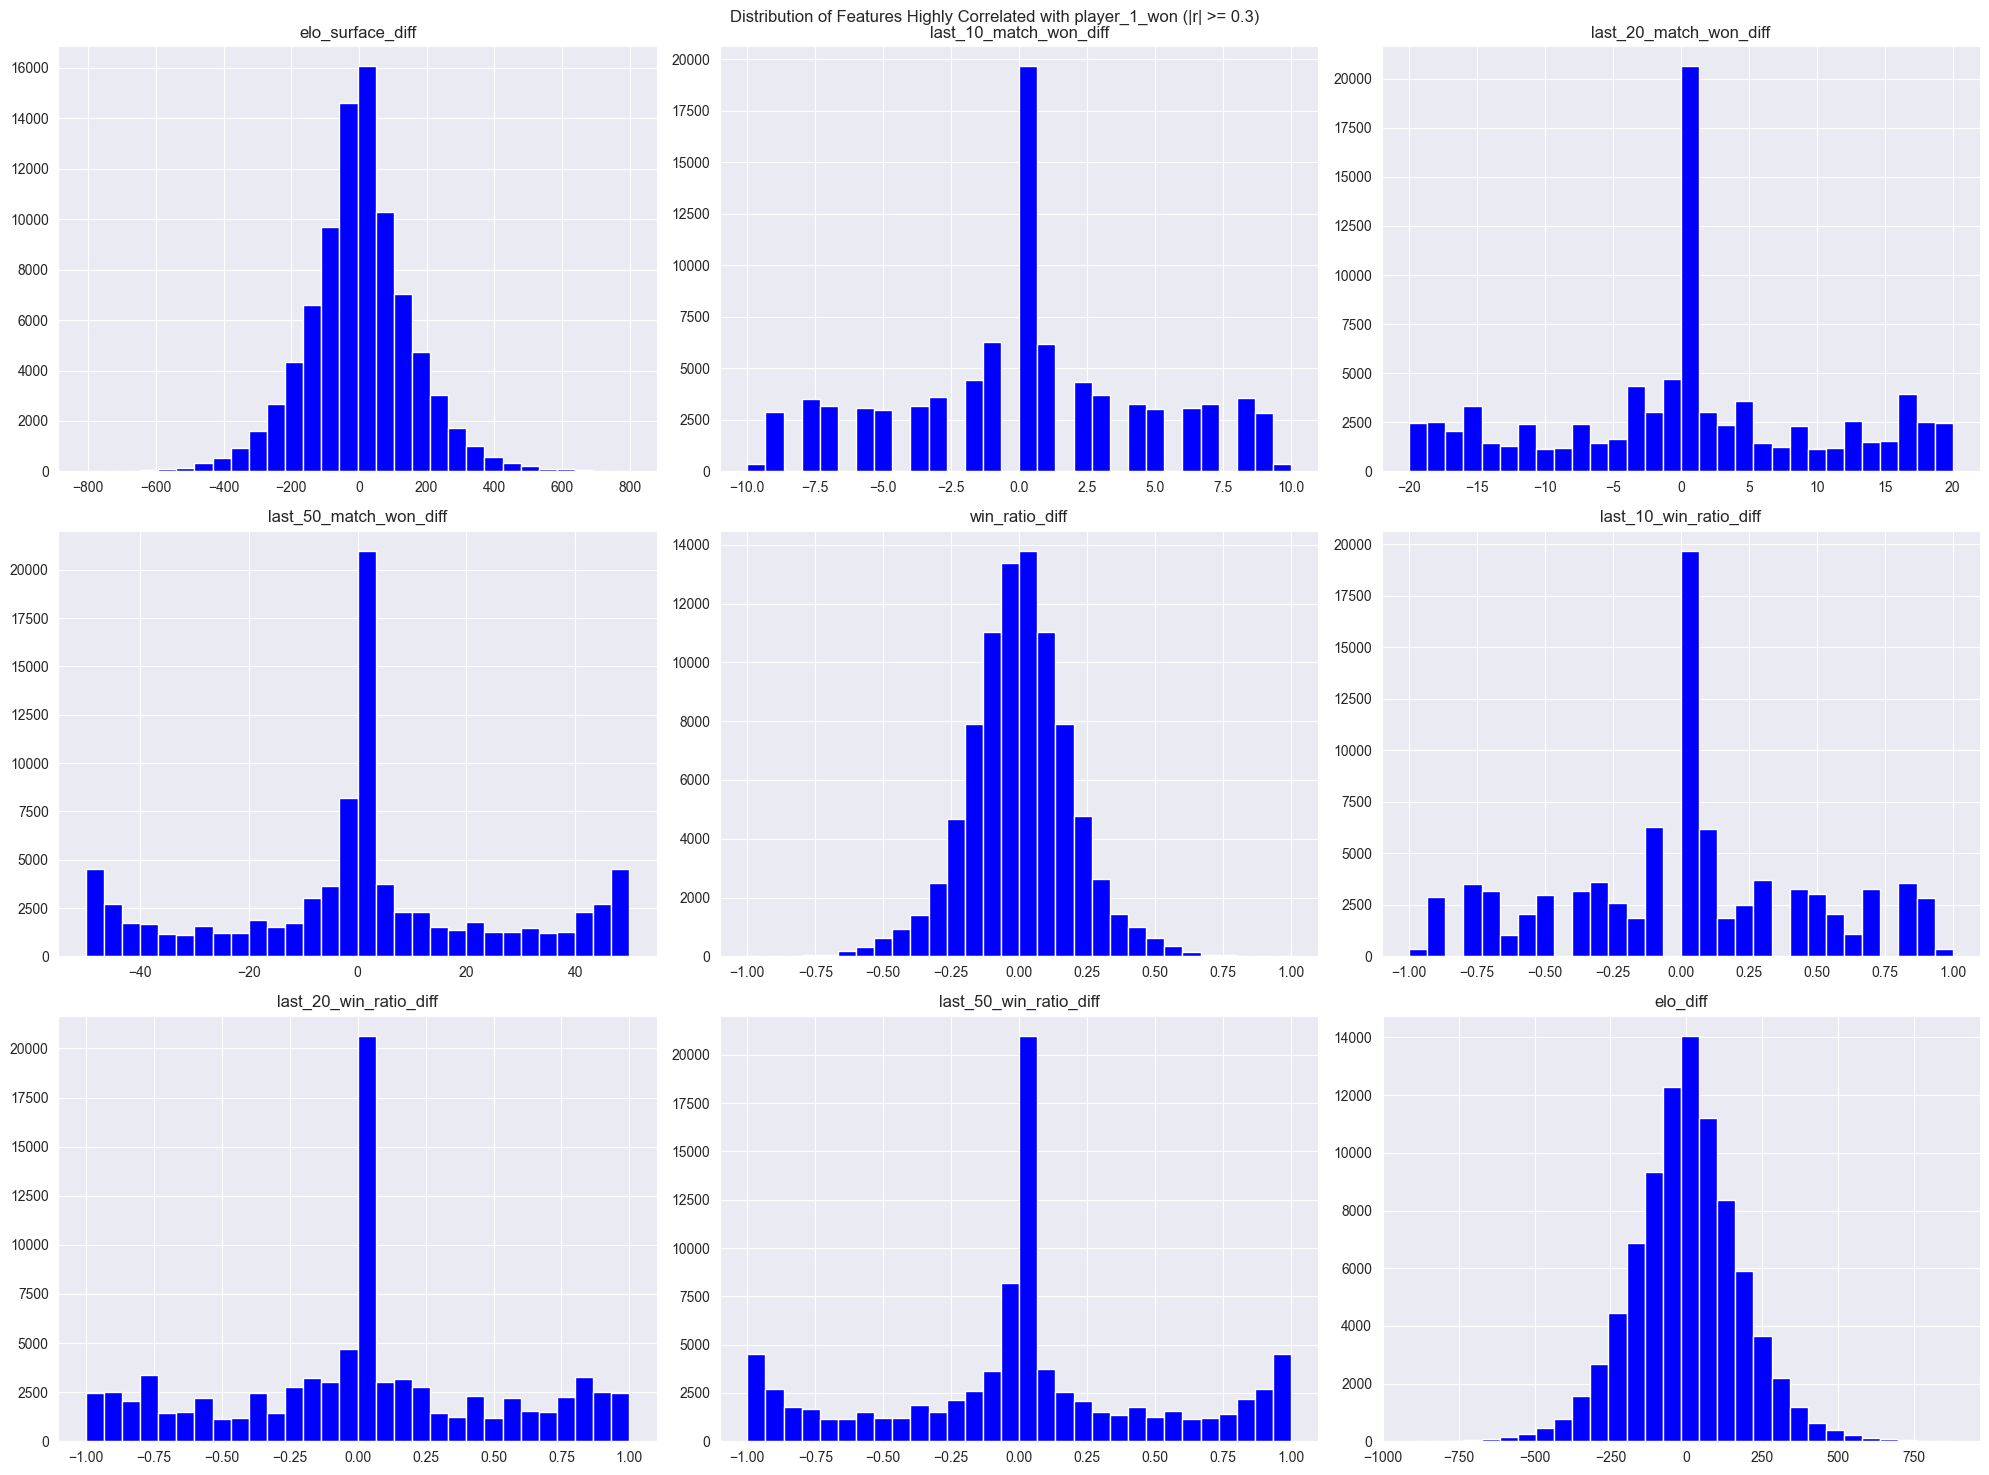

In [9]:
train_data[highly_corr_features].hist(figsize=(20, 15), bins=30, color="blue")
plt.suptitle('Distribution of Features Highly Correlated with player_1_won (|r| >= 0.3)')
plt.tight_layout()
plt.show()

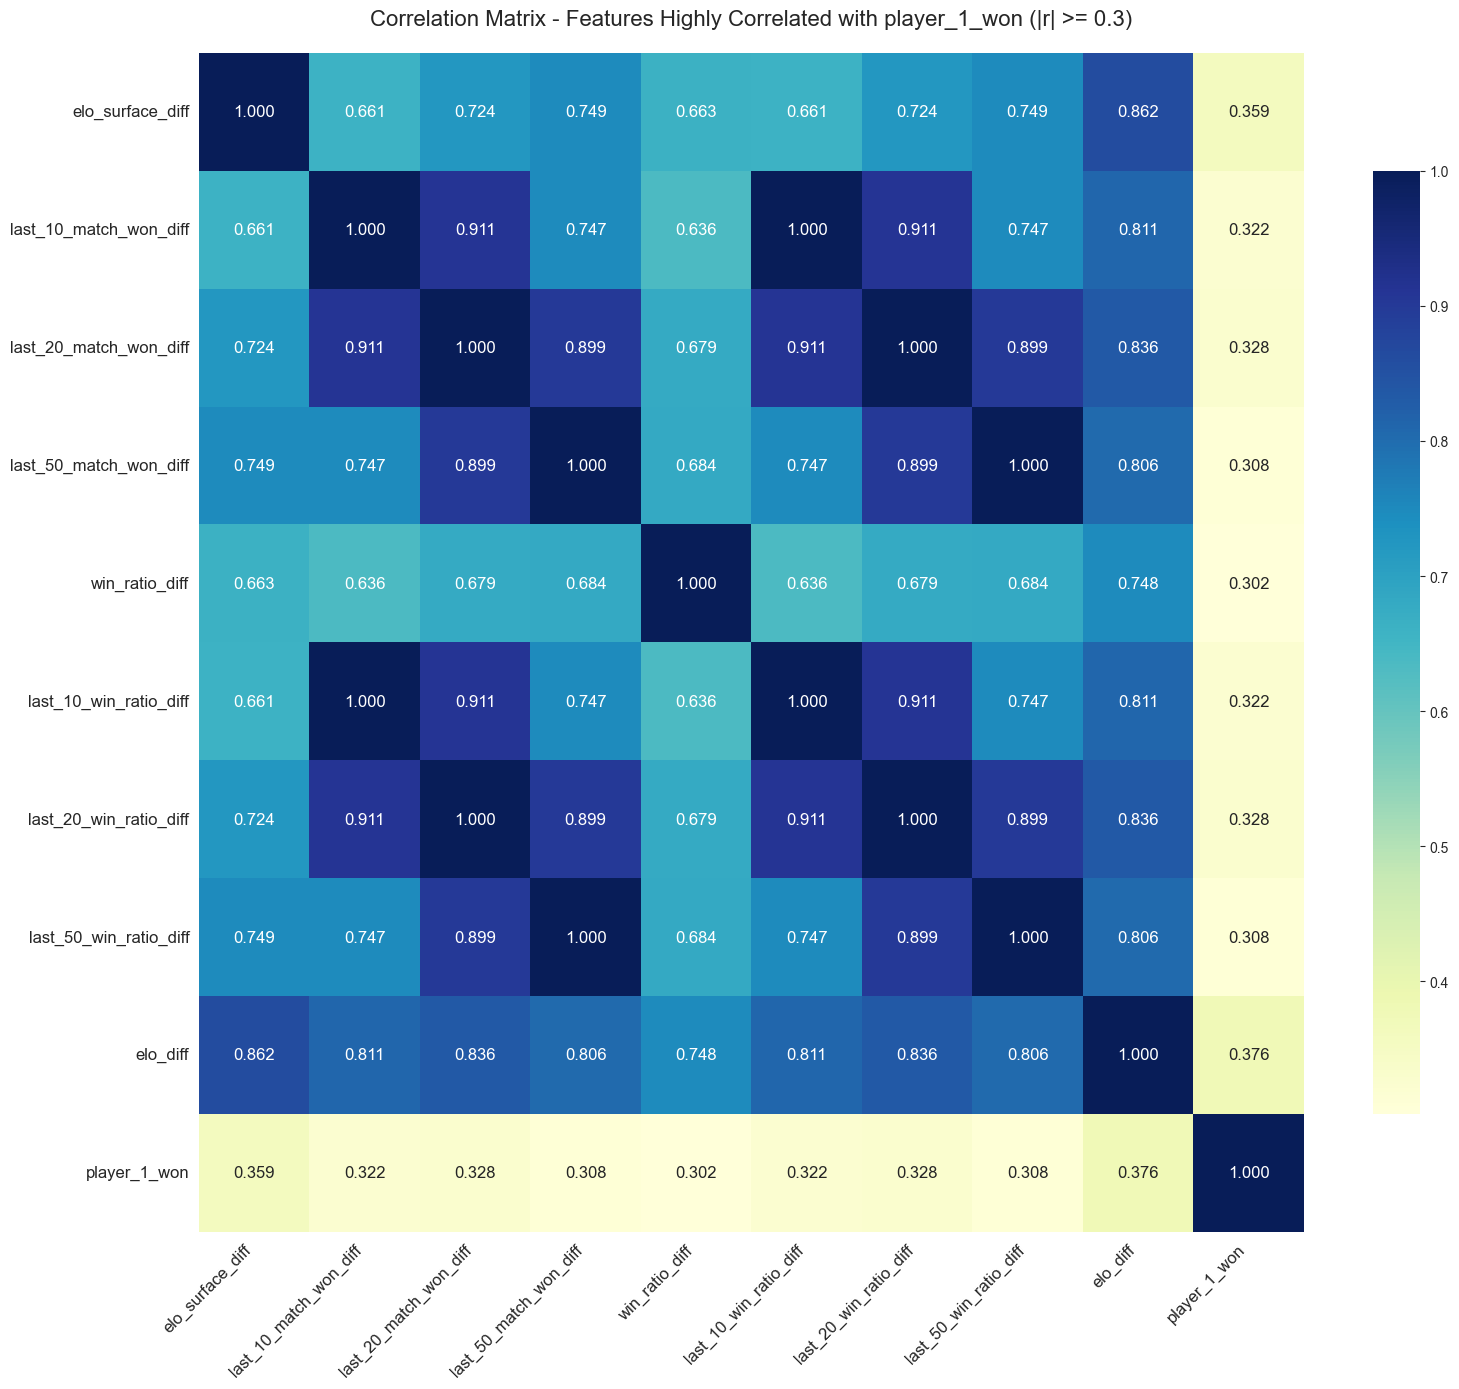

In [12]:
corr_subset = train_data[highly_corr_features].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_subset,
            annot=True,
            cmap="YlGnBu",
            fmt='.3f',
            annot_kws={'size': 12},
            cbar_kws={'shrink': 0.8})

plt.title('Correlation Matrix - Features Highly Correlated with player_1_won (|r| >= 0.3)',
          fontsize=16, pad=20)

plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

In [11]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_state=42, early_stopping_rounds=100)
model.fit(x_train, y_train, verbose=10, plot=True, eval_set=[(x_val, y_val)])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095465
0:	learn: 0.6791687	test: 0.6794862	best: 0.6794862 (0)	total: 370ms	remaining: 6m 9s
10:	learn: 0.6202411	test: 0.6205989	best: 0.6205989 (10)	total: 759ms	remaining: 1m 8s
20:	learn: 0.6075495	test: 0.6083603	best: 0.6083603 (20)	total: 1.05s	remaining: 49s
30:	learn: 0.6023518	test: 0.6032979	best: 0.6032979 (30)	total: 1.28s	remaining: 40.1s
40:	learn: 0.5995393	test: 0.6007748	best: 0.6007748 (40)	total: 1.51s	remaining: 35.4s
50:	learn: 0.5976609	test: 0.5993616	best: 0.5993616 (50)	total: 1.75s	remaining: 32.5s
60:	learn: 0.5960987	test: 0.5979200	best: 0.5979200 (60)	total: 1.96s	remaining: 30.1s
70:	learn: 0.5947381	test: 0.5968926	best: 0.5968926 (70)	total: 2.18s	remaining: 28.6s
80:	learn: 0.5936559	test: 0.5963642	best: 0.5963642 (80)	total: 2.44s	remaining: 27.7s
90:	learn: 0.5925410	test: 0.5959975	best: 0.5959658 (89)	total: 2.67s	remaining: 26.7s
100:	learn: 0.5914627	test: 0.5954664	best: 0.5954664 (100)	total: 2.9s	remaining: 25.8s
110:	

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

catboost_pred = model.predict(x_test)
catboost_proba = model.predict_proba(x_test)[:, 1]

catboost_acc = accuracy_score(y_test, catboost_pred)
catboost_auc = roc_auc_score(y_test, catboost_proba)
catboost_logloss = log_loss(y_test, catboost_proba)

print("Catboost Model Performance:")
print(f"Catboost Accuracy: {catboost_acc * 100:.2f}%")
print(f"ROC AUC: {catboost_auc:.2f}")
print(f"Log Loss: {catboost_logloss:.2f}")

Catboost Model Performance:
Catboost Accuracy: 67.21%
ROC AUC: 0.73
Log Loss: 0.60


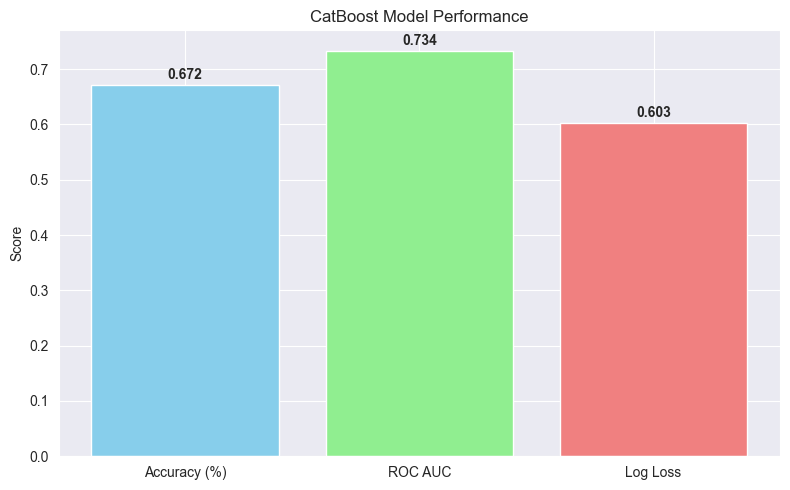

In [14]:
metrics = ['Accuracy (%)', 'ROC AUC', 'Log Loss']
values = [catboost_acc, catboost_auc, catboost_logloss]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('CatBoost Model Performance')
plt.ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [91]:
print("\nTop-10 features (PredictionValuesChange):")
print(model.get_feature_importance(prettified=True).head(10))


Top-10 features (PredictionValuesChange):
                  Feature Id  Importances
0           elo_surface_diff     9.426338
1                   elo_diff     9.076624
2                   age_diff     6.126650
3         original_rank_diff     4.189242
4           rank_points_diff     3.221933
5                  rank_diff     2.213508
6               tourney_year     1.771970
7   last_5_elo_progress_diff     1.621093
8             win_ratio_diff     1.519561
9  last_50_elo_progress_diff     1.417258


In [92]:
final_split_year = 2024

x_final_train = df[df["tourney_year"] < final_split_year].drop("player_1_won", axis=1)
y_final_train = df[df["tourney_year"] < final_split_year]["player_1_won"]

x_final_val = df[df["tourney_year"] == final_split_year].drop("player_1_won", axis=1)
y_final_val = df[df["tourney_year"] == final_split_year]["player_1_won"]

In [93]:
from catboost import CatBoostClassifier

final_model = CatBoostClassifier(random_state=42, early_stopping_rounds=100)
final_model.fit(x_final_train, y_final_train, verbose=10, plot=True,
                eval_set=[(x_final_val, y_final_val)])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.096931
0:	learn: 0.6790743	test: 0.6794717	best: 0.6794717 (0)	total: 30.5ms	remaining: 30.4s
10:	learn: 0.6208319	test: 0.6261576	best: 0.6261576 (10)	total: 304ms	remaining: 27.3s
20:	learn: 0.6071651	test: 0.6131244	best: 0.6131244 (20)	total: 555ms	remaining: 25.9s
30:	learn: 0.6023696	test: 0.6090520	best: 0.6090520 (30)	total: 785ms	remaining: 24.5s
40:	learn: 0.5996315	test: 0.6066180	best: 0.6066180 (40)	total: 1.02s	remaining: 24s
50:	learn: 0.5976864	test: 0.6053455	best: 0.6053455 (50)	total: 1.24s	remaining: 23.1s
60:	learn: 0.5960855	test: 0.6044110	best: 0.6043969 (59)	total: 1.53s	remaining: 23.6s
70:	learn: 0.5947533	test: 0.6039852	best: 0.6039143 (69)	total: 1.8s	remaining: 23.6s
80:	learn: 0.5936721	test: 0.6037615	best: 0.6036282 (76)	total: 2.07s	remaining: 23.5s
90:	learn: 0.5924919	test: 0.6029755	best: 0.6029755 (90)	total: 2.32s	remaining: 23.2s
100:	learn: 0.5914445	test: 0.6023904	best: 0.6023904 (100)	total: 2.63s	remaining: 23.4s
110:

In [94]:
from config import ROOT_DIR

final_model.save_model(f"{ROOT_DIR}/models/catboost_model.cbm")